# Getting and preparing the data



This is a modified notebook from the original fairlearn package notebook on postprocessing. This works for both Compas and Adult.

In [1]:
import pandas as pd
import numpy as np

dataset_used = 'compas'

if(dataset_used == 'compas'):
    compas_train = pd.read_csv('./../../data/compas_train.csv')
    compas_val = pd.read_csv('./../../data/compas_val.csv')
    compas_test = pd.read_csv('./../../data/compas_test.csv')

    y_train = compas_train.pop('two_year_recid') 
    y_test = compas_test.pop('two_year_recid')
    sensitive_features_train = compas_train['race']
    sensitive_features_test = compas_test['race']
    X_train = compas_train
    X_test = compas_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'African-American')
    sensitive_features_train = sensitive_features_train.replace(1, 'Caucasian')
    sensitive_features_test = sensitive_features_test.replace(0, 'African-American')
    sensitive_features_test = sensitive_features_test.replace(1, 'Caucasian')
    
elif(dataset_used == 'adult'):
    adult_train = pd.read_csv('./../../data/adult_train.csv')
    adult_val = pd.read_csv('./../../data/adult_val.csv')
    adult_test = pd.read_csv('./../../data/adult_test.csv')

    y_train = adult_train.pop('Income Binary') 
    y_test = adult_test.pop('Income Binary')
    sensitive_features_train = adult_train['sex']
    sensitive_features_test = adult_test['sex']
    X_train = adult_train
    X_test = adult_test
    
    sensitive_features_train = sensitive_features_train.replace(0, 'Female')
    sensitive_features_train = sensitive_features_train.replace(1, 'Male')
    sensitive_features_test = sensitive_features_test.replace(0, 'Female')
    sensitive_features_test = sensitive_features_test.replace(1, 'Male')
    
else:
    print('Invalid dataset_used variable.')

In [2]:
# features
X_train.loc[0], y_train[0]

(Unnamed: 0                  7796.0
 sex                            0.0
 race                           0.0
 age_cat=25 to 45               1.0
 age_cat=Greater than 45        0.0
 age_cat=Less than 25           0.0
 priors_count=0                 0.0
 priors_count=1 to 3            1.0
 priors_count=More than 3       0.0
 c_charge_degree=F              1.0
 c_charge_degree=M              0.0
 Name: 0, dtype: float64,
 1.0)

# Create a fairness-unaware model

First we set up a helper function that will help in analyzing the dataset as well as predictions from our models. Feel free to skip to the next cell for the actual logic.

*Note:* The 'recidivism' variables are, more generally, just the positive outcome variables.

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# show_proportions is only a helper function for plotting
def show_proportions(X, sensitive_features, y_pred, dataset, y=None, description=None, plot_row_index=1):
    print("\n" + description)
    plt.figure(plot_row_index)
    plt.title(description)
    positive_outcome = 'recidivism' if dataset=='compas' else 'income>50k'
    plt.ylabel("P[{} predicted | conditions]".format(positive_outcome))
    
    indices = {}
    positive_indices = {}
    negative_indices = {}
    recidivism_count = {}
    recidivism_pct = {}
    groups = np.unique(sensitive_features.values)
    n_groups = len(groups)
    max_group_length = max([len(group) for group in groups])
    color = cm.rainbow(np.linspace(0,1,n_groups))
    x_tick_labels_basic = []
    x_tick_labels_by_label = []
    for index, group in enumerate(groups):
        indices[group] = sensitive_features.index[sensitive_features == group]
        recidivism_count[group] = sum(y_pred[indices[group]])
        recidivism_pct[group] = recidivism_count[group]/len(indices[group])
        print("P[{} predicted | {}]                {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), recidivism_pct[group]))
    
        plt.bar(index + 1, recidivism_pct[group], color=color[index])
        x_tick_labels_basic.append(group)
    
        if y is not None:
            positive_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 1)]
            negative_indices[group] = sensitive_features.index[(sensitive_features == group) & (y == 0)]
            prob_1 = sum(y_pred[positive_indices[group]])/len(positive_indices[group])
            prob_0 = sum(y_pred[negative_indices[group]])/len(negative_indices[group])
            print("P[{} predicted | {}, recidivism]    {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)) , prob_1))
            print("P[{} predicted | {}, no recidivism] {}= {}".format(positive_outcome, group, " "*(max_group_length-len(group)), prob_0))

            plt.bar(n_groups + 1 + 2 * index, prob_1, color=color[index])
            plt.bar(n_groups + 2 + 2 * index, prob_0, color=color[index])
            x_tick_labels_by_label.extend(["{} {}".format(group, positive_outcome), "{} no {}".format(group, positive_outcome)])
    
    x_tick_labels = x_tick_labels_basic + x_tick_labels_by_label
    plt.xticks(range(1, len(x_tick_labels)+1), x_tick_labels, rotation=45, horizontalalignment="right")

To get started we look at a very basic Logistic Regression model. We fit it to the training data and plot some characteristics of training and test data as well as the predictions of the model on those datasets.

We notice a stark contrast in the predictions with African-Americans being a lot more likely to be predicted to reoffend, similar to the original training data. However, there's even a disparity between the subgroup of African-Americans and Caucasians with recidivism. When considering only the samples labeled with "no recidivism" African-Americans are much more likely to be predicted to reoffend than Caucasians. The test data shows a similar disparity.


original test data:
P[recidivism predicted | African-American]                = 0.5648148148148148
P[recidivism predicted | Caucasian]                       = 0.39705882352941174

fairness-unaware prediction on test data:
P[recidivism predicted | African-American]                = 0.6172839506172839
P[recidivism predicted | African-American, recidivism]    = 0.7814207650273224
P[recidivism predicted | African-American, no recidivism] = 0.40425531914893614
P[recidivism predicted | Caucasian]                       = 0.21568627450980393
P[recidivism predicted | Caucasian, recidivism]           = 0.3333333333333333
P[recidivism predicted | Caucasian, no recidivism]        = 0.13821138211382114


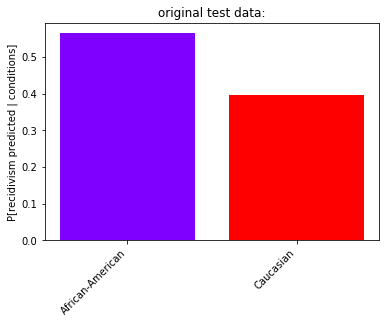

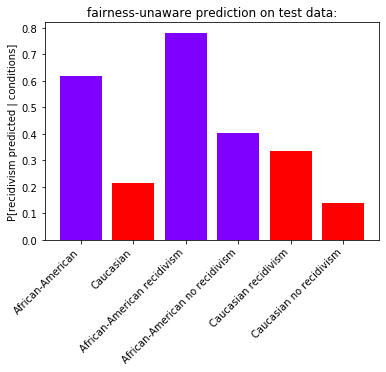

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

unconstrained_predictor = LogisticRegression(class_weight='balanced')
unconstrained_predictor.fit(X_train, y_train)
    
# print and plot data from training and test set as well as predictions with fairness-unaware classifier on both sets 
# show only test data related plots by default - uncomment the next two lines to see training data plots as well
# show_proportions(X_train, sensitive_features_train, y_train, description="original training data:", plot_row_index=1)
# show_proportions(X_train, sensitive_features_train, unconstrained_predictor.predict(X_train), y_train, description="fairness-unaware prediction on training data:", plot_row_index=2)
show_proportions(X_test, sensitive_features_test, y_test, dataset_used, description="original test data:", plot_row_index=3)
show_proportions(X_test, sensitive_features_test, unconstrained_predictor.predict(X_test), dataset_used, y_test, description="fairness-unaware prediction on test data:", plot_row_index=4)
plt.show()

# Inprocessing the model to get a fair model

The goal is to make the output fair with respect to constraints. The inprocessingalgorithm uses one of
- Demographic Parity (DP): $P\ [\ h(X)=\hat{y}\ |\ A=a] = P\ [\ h(X)=\hat{y}\ ] \qquad \forall a, \hat{y}$
- Equalized Odds (EO): $P\ [\ h(X)=\hat{y}\ |\ A=a, Y=y] = P\ [\ h(X)=\hat{y}\ |\ Y=y\ ] \qquad \forall a, \hat{y}$

where $h(X)$ is the prediction based on the input $X$, $\hat{y}$ and $y$ are labels, and $a$ is a sensitive feature value. 


equalized odds with postprocessed model on test data:
P[recidivism predicted | African-American]                = 0.5432098765432098
P[recidivism predicted | African-American, recidivism]    = 0.6502732240437158
P[recidivism predicted | African-American, no recidivism] = 0.40425531914893614
P[recidivism predicted | Caucasian]                       = 0.5049019607843137
P[recidivism predicted | Caucasian, recidivism]           = 0.6419753086419753
P[recidivism predicted | Caucasian, no recidivism]        = 0.4146341463414634


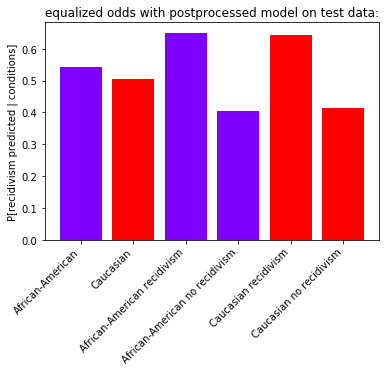

In [5]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity, EqualizedOdds
fair_constraint = 'eo' # dp, eo

if(fair_constraint =='dp'):
    expgrad_X = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=DemographicParity(),
        eps=0.01,
        nu=1e-6)
elif(fair_constraint == 'eo'):
    expgrad_X = ExponentiatedGradient(
        LogisticRegression(solver='liblinear', fit_intercept=True, class_weight='balanced'),
        constraints=EqualizedOdds(),
        eps=0.01,
        nu=1e-6)

expgrad_X.fit(X_train, y_train, sensitive_features=sensitive_features_train)

fairness_aware_predictions_train = expgrad_X.predict(X_train)
fairness_aware_predictions_test = expgrad_X.predict(X_test)

# show only test data related plot by default - uncomment the next line to see training data plot as well
# show_proportions(X_train, sensitive_features_train, fairness_aware_predictions_EO_train, y_train, description="equalized odds with postprocessed model on training data:", plot_row_index=1)
show_proportions(X_test, sensitive_features_test, fairness_aware_predictions_test, dataset_used, y_test, description="equalized odds with postprocessed model on test data:", plot_row_index=2)
plt.show()

In [9]:
from sklearn.metrics import accuracy_score
# Accuracy
accuracy_score(fairness_aware_predictions_test, y_test)

0.6193181818181818

# Export Predicted DF

In [6]:
assert(len(X_test) == len(fairness_aware_predictions_test))
X_test['predictions'] = fairness_aware_predictions_test

if(dataset_used == 'adult'):
    X_test['Income Binary'] = y_test
elif(dataset_used == 'compas'):
    X_test['two_year_recid'] = y_test
    
X_test.head(5)
X_test.to_csv('./../../predicted_data/inprocessing/inprocessing_logreg_{}_{}.csv'.format(
    dataset_used, fair_constraint))

## Export Model

In [7]:
from joblib import dump, load
if(dataset_used == 'adult'):
    dump(expgrad_X, './../../predicted_data/fair_models/inprocessing_logreg_adult.joblib')
if(dataset_used == 'compas'):
    dump(expgrad_X, './../../predicted_data/fair_models/inprocessing_logreg_compas.joblib')

PicklingError: Can't pickle <function ExponentiatedGradient._format_results.<locals>.best_classifier at 0x12cb9dd08>: it's not found as fairlearn.reductions._exponentiated_gradient.exponentiated_gradient.ExponentiatedGradient._format_results.<locals>.best_classifier